<h1 style="color:orange">QDA Exam - June 2024</h1> 
Francesco Marco Riboli - 10502512 - 8CFU

# Exercise 1

You are the new process engineer of a company that produces heavy-duty vehicles. Your first task is to design
a control chart to monitor the power consumption (in kW) of the machines installed at a metal forming station.
The station works on a 24/7 schedule. The total power consumption of the station is measured once every hour.
You are given a dataset (`power_phase1.csv`) containing the power consumption data collected from day 1 to
day 4.

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qda
from statsmodels.tsa.arima.model import ARIMA
import itertools
import statsmodels.graphics.tsaplots as sgt
from statsmodels.sandbox.stats.runs import runstest_1samp

In [2]:

# Import the dataset
phase1_data = pd.read_csv('power_phase1.csv')

# Inspect the dataset
phase1_data.head()

,Day,Hour,Power
0,1,0,18.8
1,1,1,21.4
2,1,2,19.4
3,1,3,18.0
4,1,4,20.9


In [3]:
phase1_data.describe()

,Day,Hour,Power
count,96.000000,96.000000,96.000000
mean,2.500000,11.500000,25.690625
std,1.123903,6.958524,10.386004
min,1.000000,0.000000,9.200000
25%,1.750000,5.750000,18.750000
50%,2.500000,11.500000,21.400000
75%,3.250000,17.250000,36.175000
max,4.000000,23.000000,48.200000


In [4]:
# Define the measure on which we will be running the analysis
measure='Power'

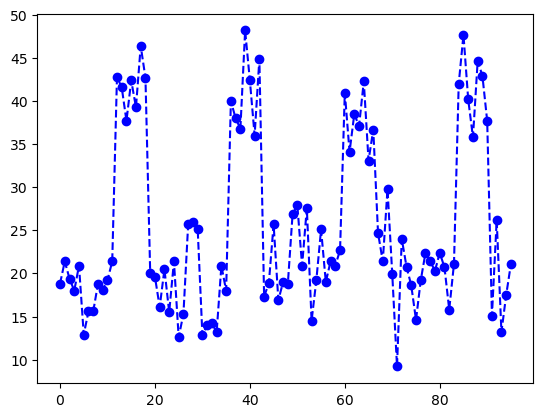

In [5]:
# Plot the data first
plt.plot(phase1_data[measure], color='b', linestyle='--', marker='o')

## a) Fitting of the appropriate model to the dataset

Runs test p-value = 0.000
The data are not random (p-value < 0.05).


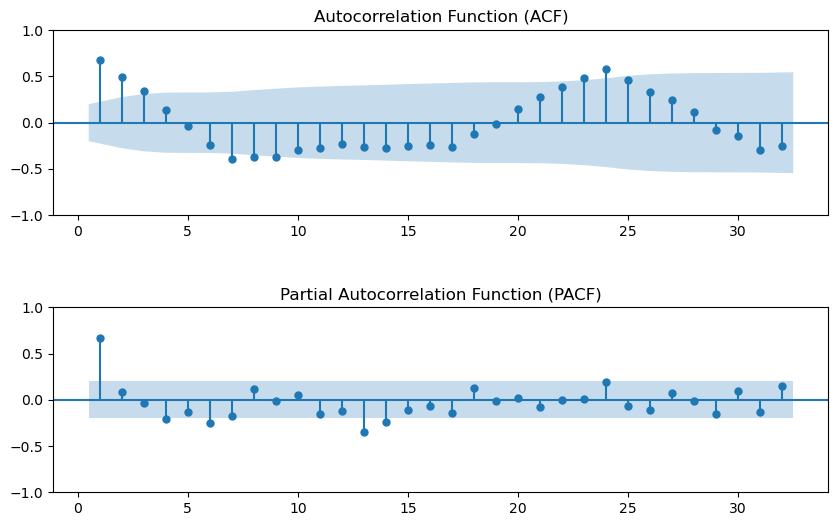

Shapiro-Wilk test p-value = 0.000
The data are not normally distributed (p-value < 0.05).


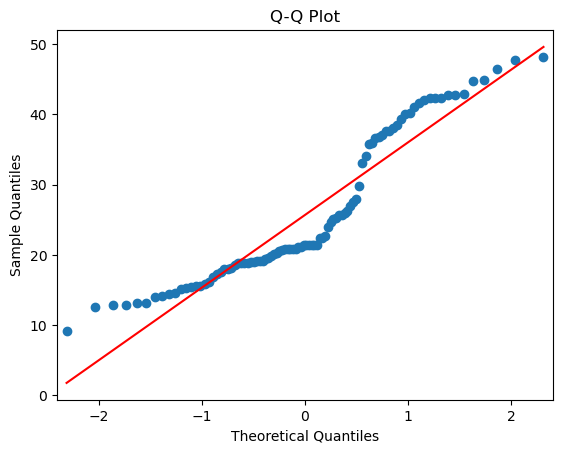

In [7]:
results = qda.runstest_acfpacf_sw(phase1_data, measure)

In [8]:
phase1_data_dum=pd.read_csv('power_phase1_dummy.csv')
phase1_data_dum.describe()

,Day,Hour,Power,Dummy
count,96.000000,96.000000,96.000000,96.000000
mean,2.500000,11.500000,25.690625,0.291667
std,1.123903,6.958524,10.386004,0.456916
min,1.000000,0.000000,9.200000,0.000000
25%,1.750000,5.750000,18.750000,0.000000
50%,2.500000,11.500000,21.400000,0.000000
75%,3.250000,17.250000,36.175000,1.000000
max,4.000000,23.000000,48.200000,1.000000


In [9]:
phase1_data_dum['lag1']=phase1_data_dum['Hour'].shift(1)
phase1_data_dum=phase1_data_dum.iloc[1:]
phase1_data_dum.describe()

,Day,Hour,Power,Dummy,lag1
count,95.000000,95.000000,95.000000,95.000000,95.000000
mean,2.515789,11.621053,25.763158,0.294737,11.378947
std,1.119110,6.893072,10.416630,0.458343,6.893072
min,1.000000,0.000000,9.200000,0.000000,0.000000
25%,2.000000,6.000000,18.700000,0.000000,5.500000
50%,3.000000,12.000000,21.400000,0.000000,11.000000
75%,3.500000,17.500000,36.350000,1.000000,17.000000
max,4.000000,23.000000,48.200000,1.000000,23.000000


In [10]:
# Calculate a regression model with constant and dummy
import statsmodels.api as sm

x = phase1_data_dum[["Dummy"]]

# Add a constant to the model.
x = sm.add_constant(x) 

y = phase1_data_dum['Power']
model = sm.OLS(y, x).fit()

# Print out the statistics
import qda
qda.summary(model)

REGRESSION EQUATION
-------------------
Power =  + 19.619 const + 20.845 Dummy

COEFFICIENTS
------------
 Term    Coef  SE Coef  T-Value    P-Value
const 19.6194   0.5098  38.4874 6.3040e-59
Dummy 20.8449   0.9390  22.1998 6.1125e-39

MODEL SUMMARY
-------------
     S   R-sq  R-sq(adj)
4.1726 0.8413     0.8395

ANALYSIS OF VARIANCE
---------------------
    Source   DF     Adj SS     Adj MS   F-Value    P-Value
Regression  1.0  8580.4120  8580.4120  492.8320 6.1125e-39
     const  1.0 25789.7052 25789.7052 1481.2799 6.3040e-59
     Dummy  1.0  8580.4120  8580.4120  492.8320 6.1125e-39
     Error 93.0  1619.1691    17.4104       NaN        NaN
     Total 94.0 10199.5811        NaN       NaN        NaN


Shapiro-Wilk test p-value on the residuals = 0.493


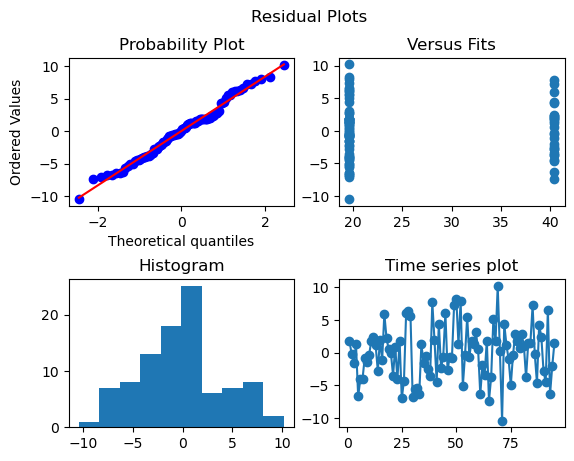

In [11]:
#NORMALITY OF RESIDUALS (PHASE 2)
residuals=model.resid
fitted=model.fittedvalues

fig, axs = plt.subplots(2, 2)
fig.suptitle('Residual Plots')

axs[0,0].set_title('Normal probability plot')
stats.probplot(residuals, dist="norm", plot=axs[0,0])

axs[0,1].set_title('Versus Fits')
axs[0,1].scatter(fitted, residuals)

fig.subplots_adjust(hspace=0.5)

axs[1,0].set_title('Histogram')
axs[1,0].hist(residuals)

axs[1,1].set_title('Time series plot')
axs[1,1].plot(np.arange(1, len(residuals)+1), residuals, 'o-')

_, pval_SW_res = stats.shapiro(residuals)
print('Shapiro-Wilk test p-value on the residuals = %.3f' % pval_SW_res)

Runs test p-value on the residuals = 0.471


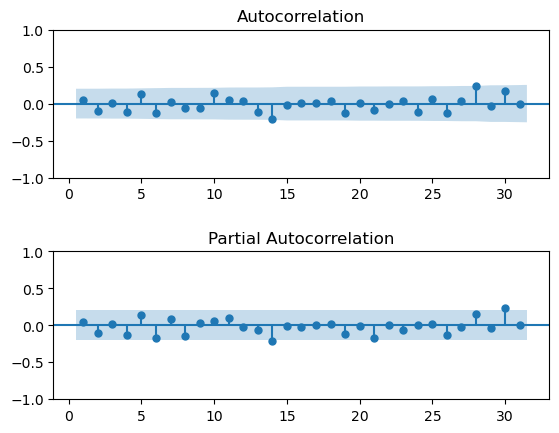

In [12]:
#RANDOMNESS OF RESIDUALS
_, pval_runs_res = runstest_1samp(residuals, correction=False)
print('Runs test p-value on the residuals = {:.3f}'.format(pval_runs_res))
fig, ax = plt.subplots(2, 1)
sgt.plot_acf(residuals, lags = int(len(residuals)/3), zero=False, ax=ax[0])
fig.subplots_adjust(hspace=0.5)
sgt.plot_pacf(residuals, lags = int(len(residuals)/3), zero=False, ax=ax[1], 
            method = 'ywm')
plt.show()

> Residuals do not show autocorrelation. Assumption on randomness of residuals is accepted.

We can move on by deifining the I-MR control chart of the new dataset

In [13]:
print(type(residuals))

<class 'pandas.core.series.Series'>


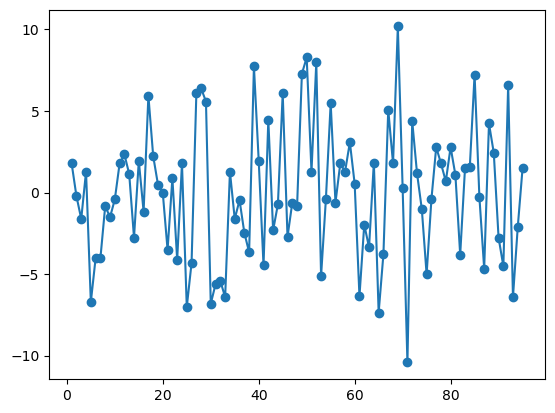

<class 'pandas.core.frame.DataFrame'>


In [14]:
# Convert residuals to DataFrame

#residuals_df = residuals.to_frame()
residuals_df=pd.DataFrame(residuals, columns=['residuals'])

# Plot the data
plt.plot(residuals_df['residuals'], 'o-')
plt.show()
print(type(residuals_df))

In [15]:
# Given information
ARL0 = 10*24
m = 1  # number of hypothesis tests

# Calculate the overall significance level
alpha = 1 / ARL0
#alpha=0.01
# Apply the Bonferroni correction
alpha_adjusted = alpha / m

# Determine the critical value k for a two-sided test
k = stats.norm.ppf(1 - alpha_adjusted / 2)

print(f"The critical value k is: {k}")

The critical value k is: 2.8652602385321346


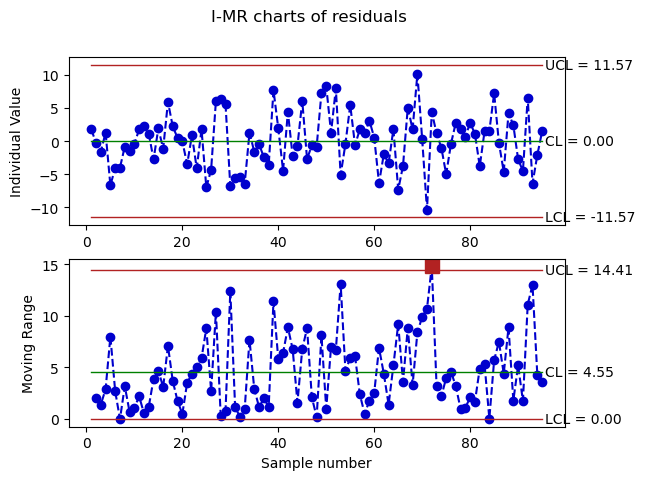

,residuals,MR,I_UCL,I_CL,I_LCL,I_TEST1,MR_UCL,MR_CL,MR_LCL,MR_TEST1
1,1.7806,NaN,11.565,3.5527e-15,-11.565,NaN,14.4137,4.5545,0,NaN
2,-0.2194,2.0,11.565,3.5527e-15,-11.565,NaN,14.4137,4.5545,0,NaN
3,-1.6194,1.4,11.565,3.5527e-15,-11.565,NaN,14.4137,4.5545,0,NaN
4,1.2806,2.9,11.565,3.5527e-15,-11.565,NaN,14.4137,4.5545,0,NaN
5,-6.7194,8.0,11.565,3.5527e-15,-11.565,NaN,14.4137,4.5545,0,NaN


In [16]:
import qda

data_IMR = qda.ControlCharts.IMR(residuals_df,'residuals',k)
data_IMR.head()

### MR with probabilistic limits - Power Transformation

When verifying the normality of the MR chart we find a non-normal distribution (half normal, per consturction), it's necessary to transform it and do again the I-MR chart

In [17]:
# Power Transformation
lambda_value=0.44
# Extract the 'MR' column   
MR = pd.DataFrame(data_IMR['MR'])

# Check if there are any values equal to 0
if (MR['MR'] == 0).any():
    # Get the index of the first value equal to 0
    idx = MR[MR['MR'] == 0].index[0]
    # Change it to NaN
    MR['MR'].iloc[idx] = np.nan

    # Transform the data
    MR['MR'] = MR['MR'].transform(lambda x: ((x**lambda_value)))

    # Replace the NaN value with 0
    MR['MR'].iloc[idx] = 0
else:
    # Transform the data without any 0 values present
    MR['MR'] = MR['MR'].transform(lambda x: ((x**lambda_value)))

MR.head()

,MR
1,NaN
2,1.3566
3,1.1596
4,1.5976
5,2.4967


p-value of the Shapiro-Wilk test: 0.602


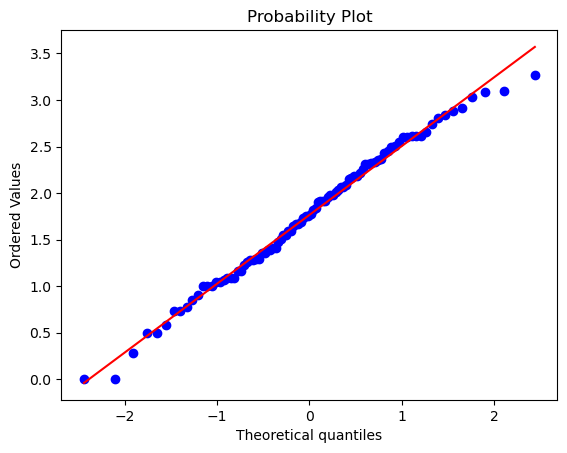

In [18]:
# We can use the Shapiro-Wilk test
data_MR_transformed_dropna = MR['MR'].dropna().to_frame()
_, p_value_SW = stats.shapiro(data_MR_transformed_dropna['MR'])
print('p-value of the Shapiro-Wilk test: %.3f' % p_value_SW)

# QQ-plot
stats.probplot(data_MR_transformed_dropna['MR'], dist="norm", plot=plt)
plt.show()

> Now you can use the I chart on the transformed data.

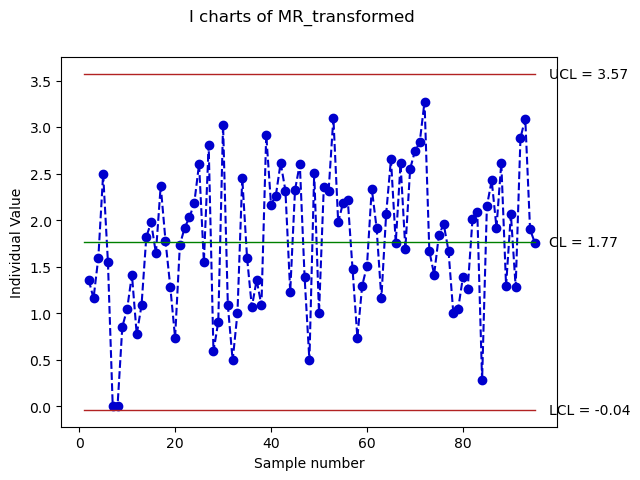

In [19]:
# Change the name of the column in MR to 'MR_transformed'
MR = MR.rename(columns = {'MR': 'MR_transformed'})
data_MR_transformed = qda.ControlCharts.IMR(MR, 'MR_transformed', K = k, plotit = False)

# Plot the I chart with the transformed data
fig, ax = plt.subplots(1, 1)
fig.suptitle(('I charts of MR_transformed'))
ax.plot(data_MR_transformed['MR_transformed'], color='mediumblue', linestyle='--', marker='o')
ax.plot(data_MR_transformed['I_UCL'], color='firebrick', linewidth=1)
ax.plot(data_MR_transformed['I_CL'], color='g', linewidth=1)
ax.plot(data_MR_transformed['I_LCL'], color='firebrick', linewidth=1)
ax.set_ylabel('Individual Value')
ax.set_xlabel('Sample number')
# add the values of the control limits on the right side of the plot
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(data_MR_transformed['I_UCL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_CL'].iloc[0], 'CL = {:.2f}'.format(data_MR_transformed['I_CL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(data_MR_transformed['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
ax.plot(data_MR_transformed['I_TEST1'], linestyle='none', marker='s', color='firebrick', markersize=10)
plt.show()


In [20]:
phase2_data_dum=pd.read_csv('power_phase2_dummy.csv')

In [21]:
def apply_model_and_calculate_phase2_residuals(model_phase1, data_phase1, data_phase2, dependent_variable):

    # Extract predictors from the model
    predictors = model_phase1.params.index.tolist()
    #print(predictors)

    # Combine the datasets
    data_combined = data_phase1.append(data_phase2).reset_index(drop=True)
    #print(data_combined.describe())

    # Prepare the combined dataset for prediction
    X_combined = data_combined[predictors[1:]]  # Exclude the constant term from the predictors array

    X_combined = sm.add_constant(X_combined)  # Add a constant to the model

    # Extract model coefficients
    coefficients = model_phase1.params

    # Calculate the predicted values for the combined dataset
    predicted_combined = X_combined @ coefficients

    # Define the dependent variable for the combined dataset
    y_combined = data_combined[dependent_variable]

    # Calculate residuals
    residuals_combined = y_combined - predicted_combined
    
    return residuals_combined, predicted_combined


In [22]:
residuals_combined, predicted_combined = apply_model_and_calculate_phase2_residuals(model, phase1_data_dum, phase2_data_dum, 'Power')

In [23]:
print(type(residuals_combined))
residuals_combined.describe()

<class 'pandas.core.series.Series'>


count    167.0000
mean       2.2058
std        5.1485
min      -10.4194
25%       -1.1643
50%        1.7806
75%        6.0306
max       14.4806
dtype: float64

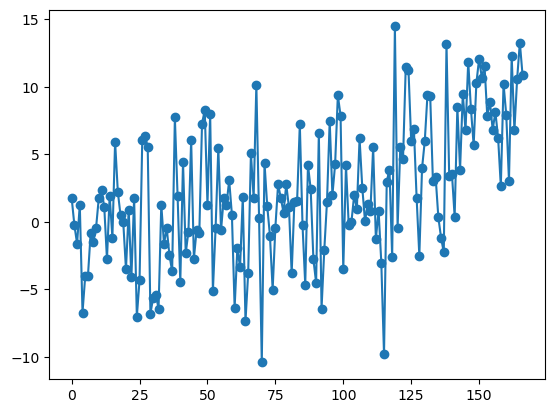

<class 'pandas.core.frame.DataFrame'>


,residuals
count,167.0000
mean,2.2058
std,5.1485
min,-10.4194
25%,-1.1643
50%,1.7806
75%,6.0306
max,14.4806


In [24]:
# Convert residuals to DataFrame

#residuals_df = residuals.to_frame()
residuals_combined_df=pd.DataFrame(residuals_combined, columns=['residuals'])

# Plot the data
plt.plot(residuals_combined_df['residuals'], 'o-')
plt.show()
print(type(residuals_combined_df))
residuals_combined_df.describe()

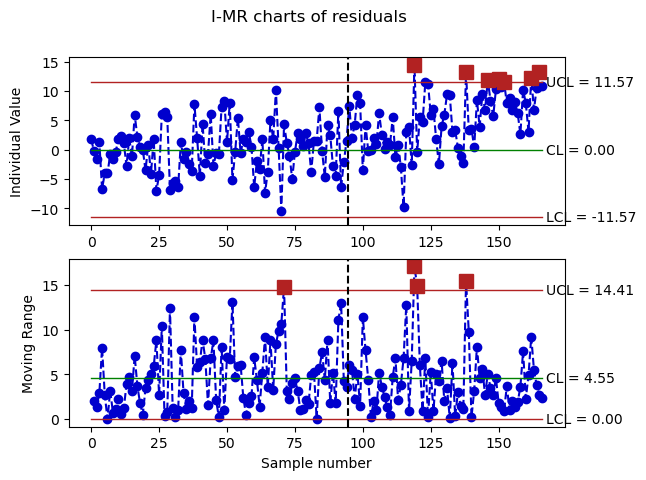

,residuals,MR,I_UCL,I_CL,I_LCL,I_TEST1,MR_UCL,MR_CL,MR_LCL,MR_TEST1
0,1.7806,NaN,11.565,3.5527e-15,-11.565,NaN,14.4137,4.5545,0,NaN
1,-0.2194,2.0,11.565,3.5527e-15,-11.565,NaN,14.4137,4.5545,0,NaN
2,-1.6194,1.4,11.565,3.5527e-15,-11.565,NaN,14.4137,4.5545,0,NaN
3,1.2806,2.9,11.565,3.5527e-15,-11.565,NaN,14.4137,4.5545,0,NaN
4,-6.7194,8.0,11.565,3.5527e-15,-11.565,NaN,14.4137,4.5545,0,NaN


In [25]:
import qda

data_IMR = qda.ControlCharts.IMR(residuals_combined_df,'residuals',k,subset_size=95)
data_IMR.head()

In [26]:
# Find the index of the I_TEST1 column different from NaN
OOC_idx = np.where(data_IMR['I_TEST1'].notnull())[0]
# Print the index of the OOC points
print('The index of the OOC point is: {}'.format(OOC_idx))

# Find the index of the I_TEST1 on MR column different from NaN
OOC_idx = np.where(data_MR_transformed['I_TEST1'].notnull())[0]
# Print the index of the OOC points
print('The index of the OOC point is: {}'.format(OOC_idx))

The index of the OOC point is: [119 138 146 150 152 162 165]
The index of the OOC point is: []


In [27]:
# Power Transformation
lambda_value=0.4
# Extract the 'MR' column   
MR = pd.DataFrame(data_IMR['MR'])

# Check if there are any values equal to 0
if (MR['MR'] == 0).any():
    # Get the index of the first value equal to 0
    idx = MR[MR['MR'] == 0].index[0]
    # Change it to NaN
    MR['MR'].iloc[idx] = np.nan

    # Transform the data
    MR['MR'] = MR['MR'].transform(lambda x: ((x**lambda_value)))

    # Replace the NaN value with 0
    MR['MR'].iloc[idx] = 0
else:
    # Transform the data without any 0 values present
    MR['MR'] = MR['MR'].transform(lambda x: ((x**lambda_value)))

MR.describe()

,MR
count,166.0000
mean,1.6652
std,0.6086
min,0.0000
25%,1.2523
50%,1.6734
75%,2.0979
max,3.1131


p-value of the Shapiro-Wilk test: 0.881


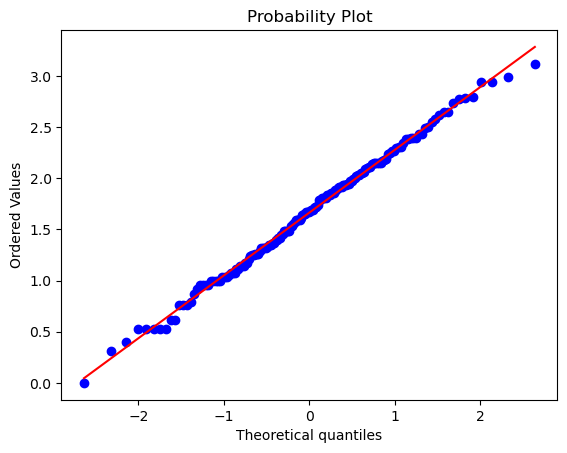

In [28]:
# We can use the Shapiro-Wilk test
data_MR_transformed_dropna = MR['MR'].dropna().to_frame()
_, p_value_SW = stats.shapiro(data_MR_transformed_dropna['MR'])
print('p-value of the Shapiro-Wilk test: %.3f' % p_value_SW)

# QQ-plot
stats.probplot(data_MR_transformed_dropna['MR'], dist="norm", plot=plt)
plt.show()

> Now you can use the I chart on the transformed data.

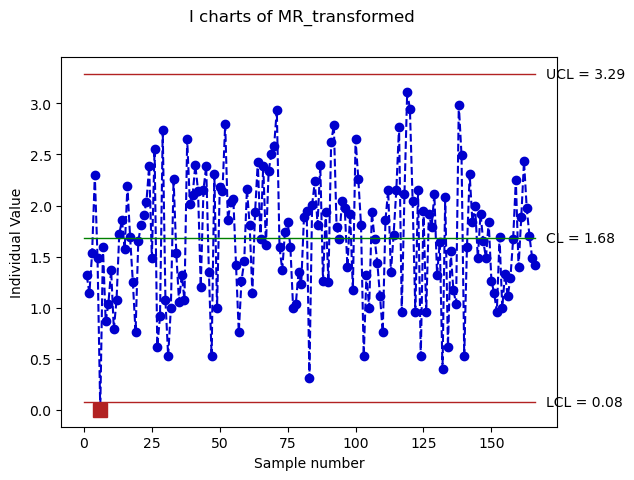

In [29]:
# Change the name of the column in MR to 'MR_transformed'
MR = MR.rename(columns = {'MR': 'MR_transformed'})
data_MR_transformed = qda.ControlCharts.IMR(MR, 'MR_transformed', K = k,subset_size=96, plotit = False)

# Plot the I chart with the transformed data
fig, ax = plt.subplots(1, 1)
fig.suptitle(('I charts of MR_transformed'))
ax.plot(data_MR_transformed['MR_transformed'], color='mediumblue', linestyle='--', marker='o')
ax.plot(data_MR_transformed['I_UCL'], color='firebrick', linewidth=1)
ax.plot(data_MR_transformed['I_CL'], color='g', linewidth=1)
ax.plot(data_MR_transformed['I_LCL'], color='firebrick', linewidth=1)
ax.set_ylabel('Individual Value')
ax.set_xlabel('Sample number')
# add the values of the control limits on the right side of the plot
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_UCL'].iloc[0], 'UCL = {:.2f}'.format(data_MR_transformed['I_UCL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_CL'].iloc[0], 'CL = {:.2f}'.format(data_MR_transformed['I_CL'].iloc[0]), verticalalignment='center')
ax.text(len(data_MR_transformed)+3, data_MR_transformed['I_LCL'].iloc[0], 'LCL = {:.2f}'.format(data_MR_transformed['I_LCL'].iloc[0]), verticalalignment='center')
# highlight the points that violate the alarm rules
ax.plot(data_MR_transformed['I_TEST1'], linestyle='none', marker='s', color='firebrick', markersize=10)
plt.show()


In [31]:
# Predict the diameter using the fitted linear model
phase1_data_dum['Power Predicted'] = model.predict(x)

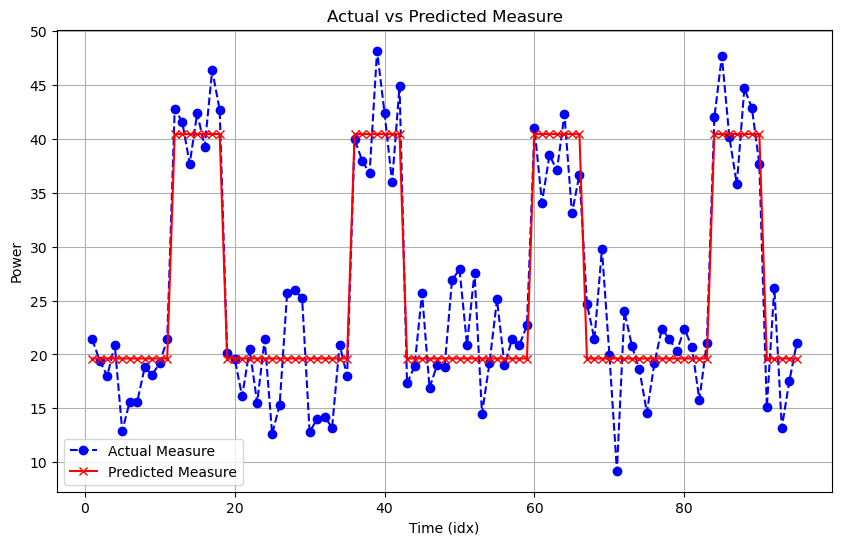

In [32]:
# Plot the actual and predicted diameter values on the same plot
plt.figure(figsize=(10, 6))
plt.plot(phase1_data_dum.index, phase1_data_dum['Power'], marker='o', linestyle='--', color='b', label='Actual Measure')
plt.plot(phase1_data_dum.index, phase1_data_dum['Power Predicted'], marker='x', linestyle='-', color='r', label='Predicted Measure')
plt.title('Actual vs Predicted Measure')
plt.xlabel('Time (idx)')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
data_combined = phase1_data_dum.append(phase2_data_dum).reset_index(drop=True)

In [36]:
# Predict the diameter using the fitted linear model
x = data_combined[["Dummy"]]

# Add a constant to the model.
x = sm.add_constant(x) 
data_combined['Power Predicted'] = model.predict(x)

95


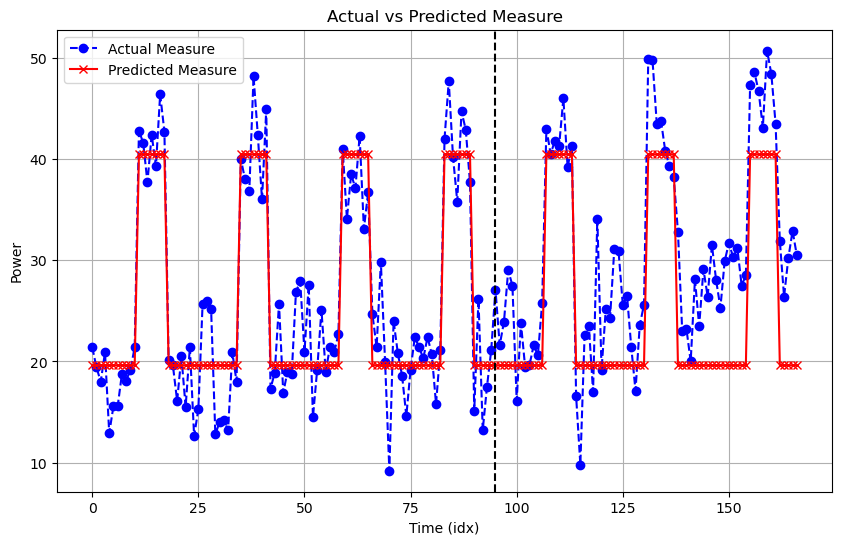

In [41]:
# Plot the actual and predicted diameter values on the same plot
plt.figure(figsize=(10, 6))
plt.plot(data_combined.index, data_combined['Power'], marker='o', linestyle='--', color='b', label='Actual Measure')
plt.plot(data_combined.index, data_combined['Power Predicted'], marker='x', linestyle='-', color='r', label='Predicted Measure')
plt.title('Actual vs Predicted Measure')
plt.xlabel('Time (idx)')
plt.ylabel('Power')
plt.legend()
plt.axvline(x=len(phase1_data_dum), color='k', linestyle='--')
print(len(phase1_data_dum))
plt.grid(True)
plt.show()

## Creation of the dummy variable inside Python
You need to use the lambda function...

In [44]:
phase1_data['DummyTest'] = phase1_data['Hour'].apply(lambda x: 1 if 12 <= x <= 18 else 0)
phase1_data.describe()

,Day,Hour,Power,DummyTest
count,96.0000,96.0000,96.0000,96.0000
mean,2.5000,11.5000,25.6906,0.2917
std,1.1239,6.9585,10.3860,0.4569
min,1.0000,0.0000,9.2000,0.0000
25%,1.7500,5.7500,18.7500,0.0000
50%,2.5000,11.5000,21.4000,0.0000
75%,3.2500,17.2500,36.1750,1.0000
max,4.0000,23.0000,48.2000,1.0000
